# Individual Modeling Notebook

In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from google.cloud import storage
import os
from io import StringIO
import json
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/IWC_Work_Orders_Extract.csv'
df = pd.read_csv(file_path)
df.head()

<ipython-input-84-5a469f7686b9>:2: DtypeWarning: Columns (8,11,12,13,14,15,16,17,18,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
0,705642457,G812,ROMA,2024-05-04,2024-05-12,06:00:00.000,23:04:08.000,390.0,NaN,NaN,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
1,704191697,G812,ROMA,2022-09-13,2022-09-13,06:00:00.000,17:17:24.000,420.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR AT CAN CODER,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
2,704466547,G812,ROMA,2022-12-21,2022-12-21,07:00:00.000,07:00:00.000,30.0,NaN,NaN,Unplanned,BROKEN CONVEYOR RAIL,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
3,703834477,G812,ROMA,2022-07-04,2022-07-04,06:00:00.000,06:00:00.000,60.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
4,704661125,G291,MONZA,2023-03-15,2023-03-15,07:00:00.000,07:00:00.000,120.0,NaN,NaN,Unplanned,REPLACED SONIC AIR BLOWER BELT,Corrective Maintenance Order,G291-PRD-P05,MONZA PRODUCTION,AIR SYSTEMS,NaN,NaN,NaN,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,9999-12-31


In [ ]:
# Quick inspection of the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427264 entries, 0 to 1427263
Data columns (total 25 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   ORDER_ID                         1427264 non-null  int64  
 1   PLANT_ID                         1427264 non-null  object 
 2   PRODUCTION_LOCATION              1427264 non-null  object 
 3   EXECUTION_START_DATE             1427264 non-null  object 
 4   EXECUTION_FINISH_DATE            1427264 non-null  object 
 5   ACTUAL_START_TIME                1427264 non-null  object 
 6   ACTUAL_FINISH_TIME               1427264 non-null  object 
 7   ACTUAL_WORK_IN_MINUTES           1427264 non-null  float64
 8   MAINTENANCE_PLAN                 152594 non-null   object 
 9   MAINTENANCE_ITEM                 152594 non-null   float64
 10  MAINTENANCE_ACTIVITY_TYPE        1427264 non-null  object 
 11  ORDER_DESCRIPTION                291767 non-null  

In [ ]:
df.describe()

,ORDER_ID,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_ITEM,EQUIPMENT_ID
count,1.427264e+06,1.427264e+06,152594.000000,2.917950e+05
mean,4.561470e+10,8.862968e+01,115846.807954,3.002609e+08
std,8.387114e+10,8.037915e+02,71325.255687,5.581645e+06
min,1.000219e+08,0.000000e+00,39801.000000,2.000871e+08
25%,4.022602e+08,1.200000e+01,41046.000000,3.000092e+08
50%,7.044271e+08,4.800000e+01,112995.000000,3.000178e+08
75%,1.002343e+09,9.000000e+01,134702.000000,3.000269e+08
max,9.000001e+11,3.301848e+05,346352.000000,4.000290e+08


In [ ]:
# Identify and convert any date columns based on their names
date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Check the data types to confirm date conversions
print(df[date_columns].dtypes)


<ipython-input-39-2fb213e87c29>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-39-2fb213e87c29>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


EXECUTION_START_DATE     datetime64[ns]
EXECUTION_FINISH_DATE    datetime64[ns]
ACTUAL_START_TIME        datetime64[ns]
ACTUAL_FINISH_TIME       datetime64[ns]
EQUIP_START_UP_DATE      datetime64[ns]
dtype: object


Filtering data for future models

In [ ]:
# Filter data to include only entries from 2017 onwards
df = df[df['EXECUTION_START_DATE'] >= '2017-01-01']

# Ensure the date column is in the correct format for monthly aggregation
df['START_YEAR_MONTH'] = df['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()

# Aggregate the data by month
monthly_data = df.groupby('START_YEAR_MONTH')['ACTUAL_WORK_IN_MINUTES'].sum().reset_index()

# Rename columns to match Prophet's requirements
monthly_data.columns = ['ds', 'y']

# Display the first few rows of the prepared data for Prophet
monthly_data.head()

,ds,y
0,2017-01-01,484863.2
1,2017-02-01,369338.6
2,2017-03-01,639472.6
3,2017-04-01,773963.0
4,2017-05-01,928150.6


## Exploring the Prophet Model

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/1ly7dmzm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/vfpn8mlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80246', 'data', 'file=/tmp/tmp29ok24fn/1ly7dmzm.json', 'init=/tmp/tmp29ok24fn/vfpn8mlz.json', 'output', 'file=/tmp/tmp29ok24fn/prophet_modelil8a9tfe/prophet_model-20241102184616.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:46:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages

Mean Squared Error (MSE): 4705057766.434859
R-squared: 0.6454982539844223


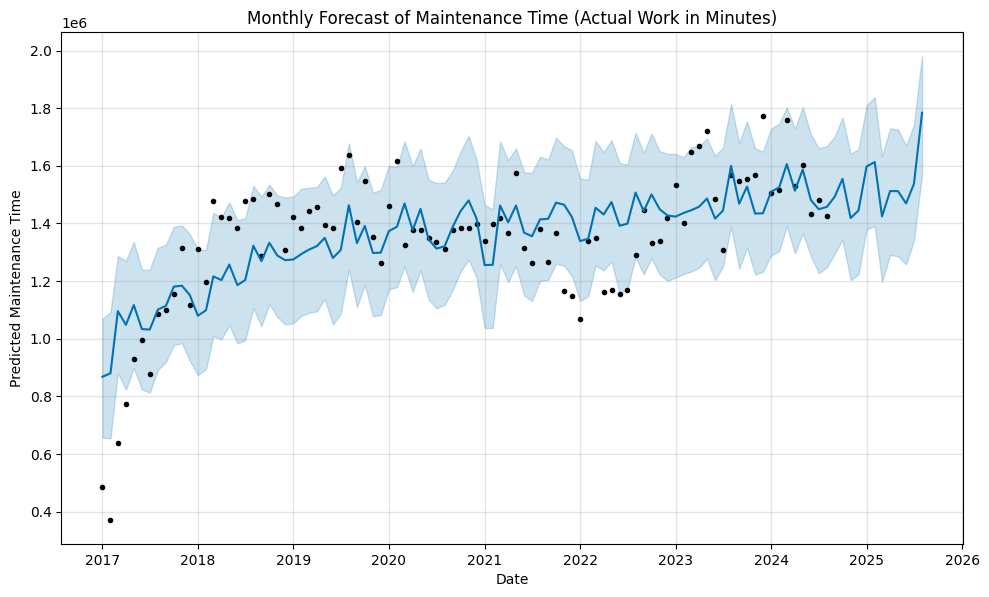

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize the Prophet model
model = Prophet()

# Fit the model on the aggregated monthly data
model.fit(monthly_data)

# Define the prediction horizon (e.g., 12 months into the future)
future = model.make_future_dataframe(periods=12, freq='M')

# Generate forecast
forecast = model.predict(future)

# Define the validation period (e.g., last 6 months of actuals)
validation_period = monthly_data['ds'][-6:]
actual_values = monthly_data.set_index('ds').loc[validation_period, 'y']
predicted_values = forecast.set_index('ds').loc[validation_period, 'yhat']

# Calculate performance metrics
mse = mean_squared_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

# Output the performance metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
fig = model.plot(forecast)
plt.title("Monthly Forecast of Maintenance Time (Actual Work in Minutes)")
plt.xlabel("Date")
plt.ylabel("Predicted Maintenance Time")
plt.show()

The monthly forecast model yields an R-squared of 0.65, suggesting that it captures a reasonable portion of the variability in maintenance time over time. However, the MSE remains high, indicating that some larger deviations between the forecasted and actual values persist, likely due to unaccounted variability within each month. This balance suggests that while the model is generally capturing the trend, further tuning or additional factors might help improve accuracy.

### Aggregate by production location and Month

In [ ]:
# Aggregate data by Production Location and Month
location_monthly_data = df.groupby([pd.Grouper(key='EXECUTION_START_DATE', freq='MS'), 'PRODUCTION_LOCATION'])['ACTUAL_WORK_IN_MINUTES'].sum().reset_index()

# Rename columns for Prophet compatibility
location_monthly_data.columns = ['ds', 'PRODUCTION_LOCATION', 'y']

# Display the first few rows to confirm
print(location_monthly_data.head())

          ds PRODUCTION_LOCATION         y
0 2017-01-01         SILVERSTONE  484863.2
1 2017-02-01               MONZA    9459.2
2 2017-02-01         SILVERSTONE  359879.4
3 2017-03-01               MONZA  221138.2
4 2017-03-01         SILVERSTONE  418334.4


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/xqw96b0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/n7nz8vdi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71348', 'data', 'file=/tmp/tmp29ok24fn/xqw96b0m.json', 'init=/tmp/tmp29ok24fn/n7nz8vdi.json', 'output', 'file=/tmp/tmp29ok24fn/prophet_models13ujzfv/prophet_model-20241102185158.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:51:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing location: SILVERSTONE


18:51:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


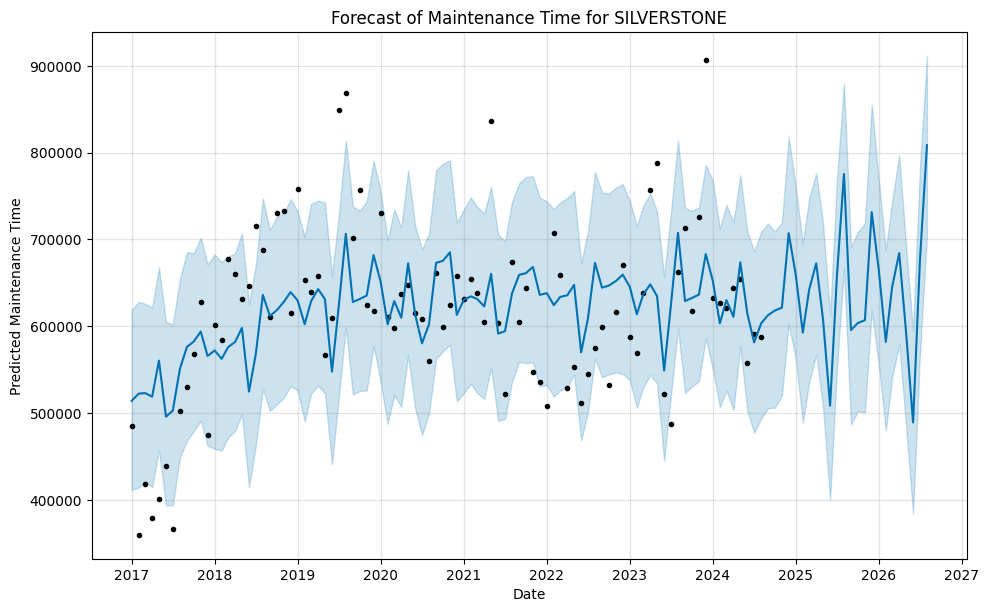

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/4fp1s6f7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/nnznxoo2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30309', 'data', 'file=/tmp/tmp29ok24fn/4fp1s6f7.json', 'init=/tmp/tmp29ok24fn/nnznxoo2.json', 'output', 'file=/tmp/tmp29ok24fn/prophet_modeliltnc4kz/prophet_model-20241102185159.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:51:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing location: MONZA


18:52:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


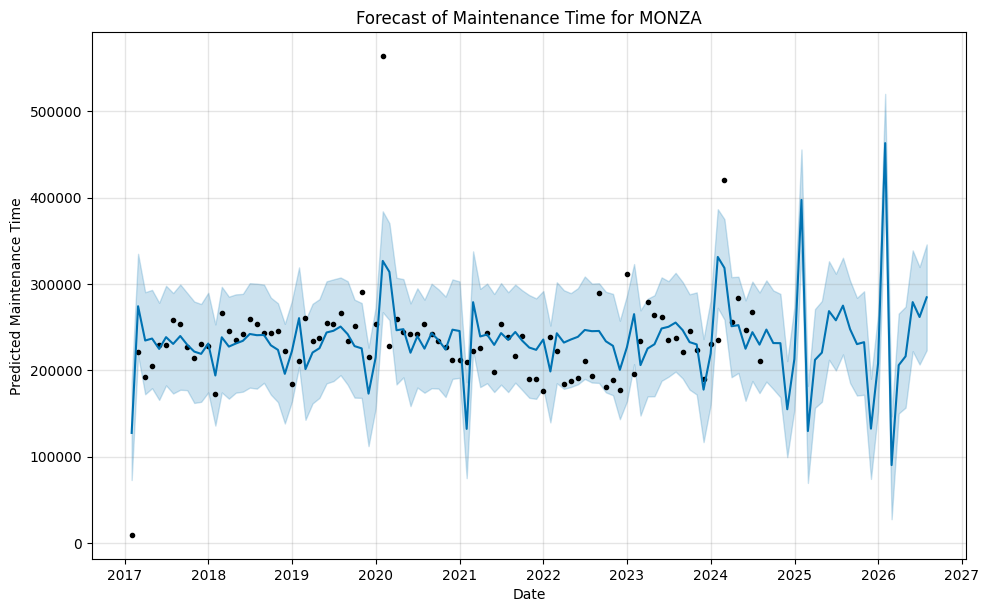

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/sejp8idm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/51gkfgf4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60439', 'data', 'file=/tmp/tmp29ok24fn/sejp8idm.json', 'init=/tmp/tmp29ok24fn/51gkfgf4.json', 'output', 'file=/tmp/tmp29ok24fn/prophet_model6xukyrhn/prophet_model-20241102185200.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:52:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing location: SUZUKA


18:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


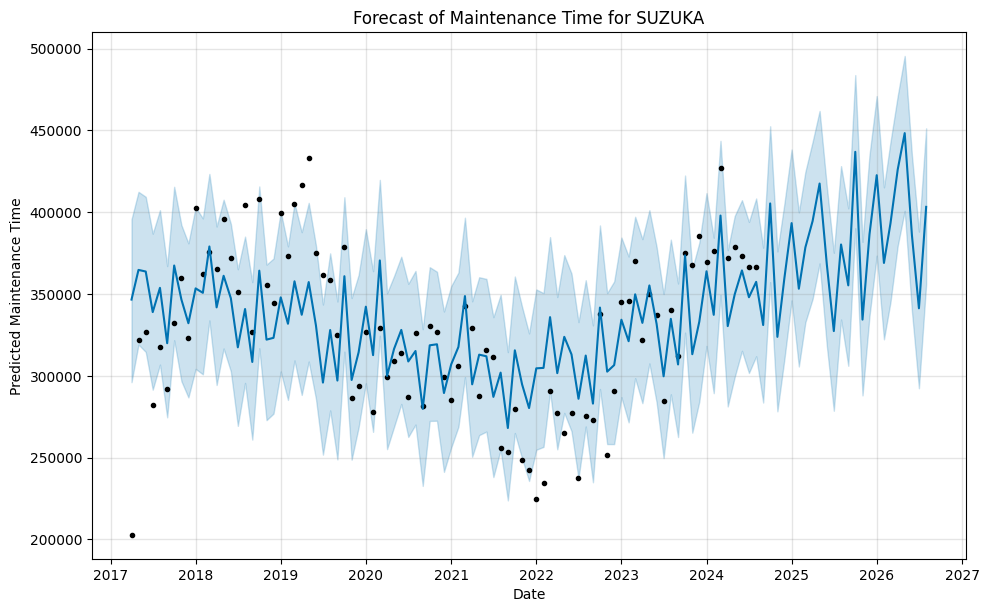

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/z4w_5vy8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/a5l6j8yp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29380', 'data', 'file=/tmp/tmp29ok24fn/z4w_5vy8.json', 'init=/tmp/tmp29ok24fn/a5l6j8yp.json', 'output', 'file=/tmp/tmp29ok24fn/prophet_model5glaj11i/prophet_model-20241102185201.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing location: ROMA


18:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


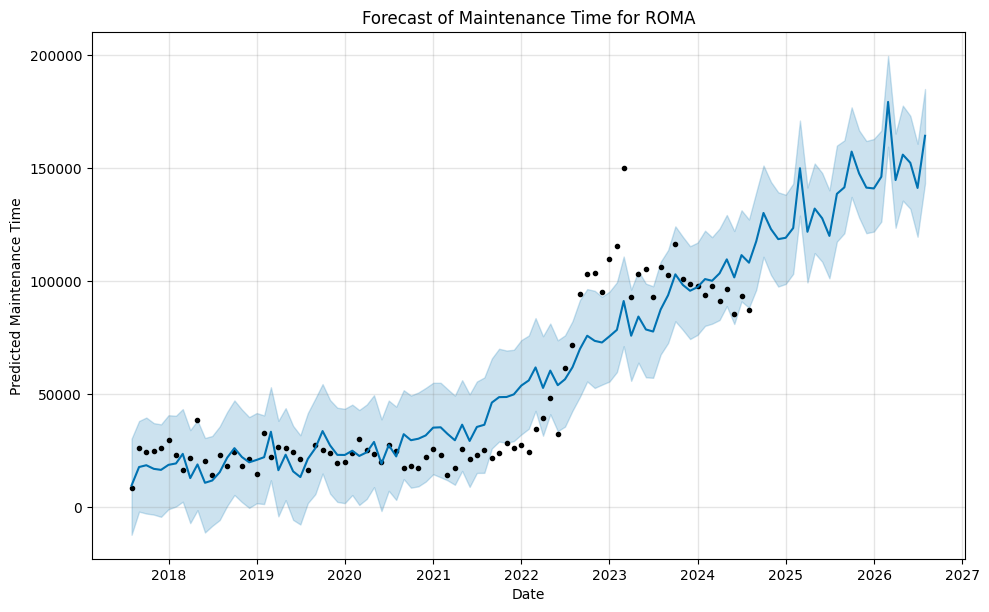

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/tejb_buh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/h73b955k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57437', 'data', 'file=/tmp/tmp29ok24fn/tejb_buh.json', 'init=/tmp/tmp29ok24fn/h73b955k.json', 'output', 'file=/tmp/tmp29ok24fn/prophet_modelyq7xq199/prophet_model-20241102185202.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:52:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing location: COTA


18:52:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


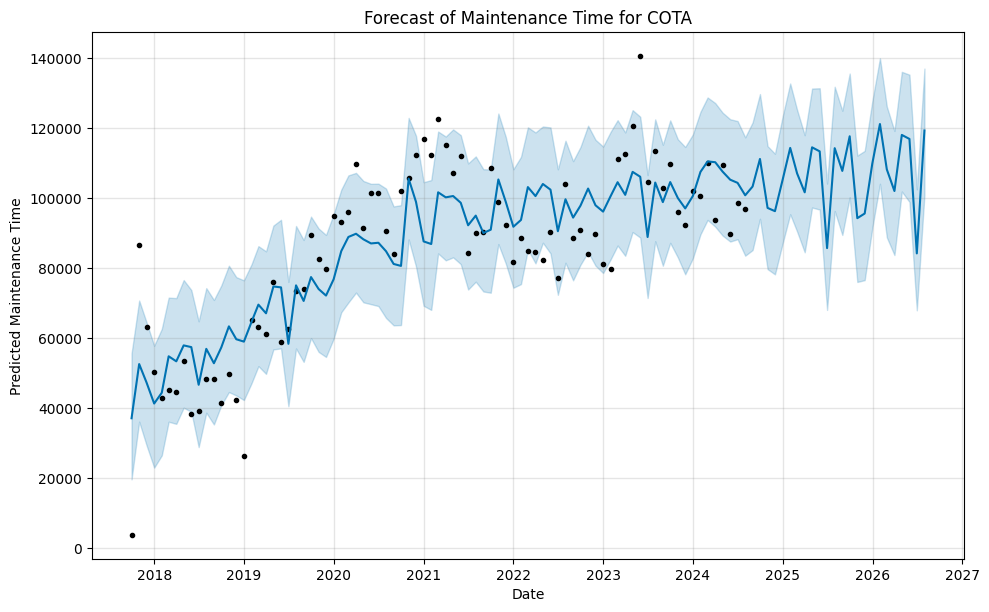

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/rvc4qc4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/4xqdquer.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13794', 'data', 'file=/tmp/tmp29ok24fn/rvc4qc4a.json', 'init=/tmp/tmp29ok24fn/4xqdquer.json', 'output', 'file=/tmp/tmp29ok24fn/prophet_modelj5sp4ggn/prophet_model-20241102185203.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:52:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Processing location: MONACO


18:52:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


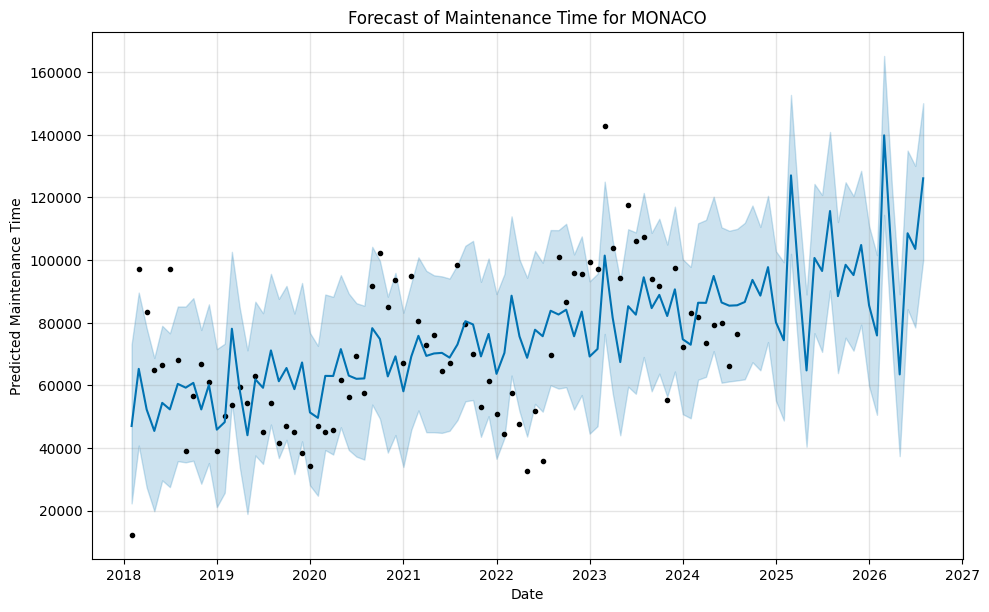

In [ ]:
# Dictionary to store forecasts and performance metrics by location
forecasts_by_location = {}
prophet_metrics_by_location = {}

# Loop through each production location
for location in location_monthly_data['PRODUCTION_LOCATION'].unique():
    print(f"Processing location: {location}")

    # Filter data for the current location
    location_data = location_monthly_data[location_monthly_data['PRODUCTION_LOCATION'] == location]

    # Initialize and fit Prophet model
    model = Prophet()
    model.fit(location_data[['ds', 'y']])

    # Define the prediction horizon
    future = model.make_future_dataframe(periods=24, freq='M')

    # Generate forecast
    forecast = model.predict(future)

    # Store forecast in the dictionary
    forecasts_by_location[location] = forecast

    # Define the validation period
    validation_period = location_data['ds'][-6:]
    actual_values = location_data.set_index('ds').loc[validation_period, 'y']
    predicted_values = forecast.set_index('ds').loc[validation_period, 'yhat']

    # Plot the forecast for the current location
    fig = model.plot(forecast)
    plt.title(f"Forecast of Maintenance Time for {location}")
    plt.xlabel("Date")
    plt.ylabel("Predicted Maintenance Time")
    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Dictionary to store performance metrics by location
prophet_metrics_by_location = {}

# Loop through each production location to calculate performance metrics
for location, forecast in forecasts_by_location.items():
    print(f"Calculating performance metrics for location: {location}")

    # Retrieve the actual data for the validation period
    location_data = location_monthly_data[location_monthly_data['PRODUCTION_LOCATION'] == location]
    validation_period = location_data['ds'][-6:]
    actual_values = location_data.set_index('ds').loc[validation_period, 'y']
    predicted_values = forecast.set_index('ds').loc[validation_period, 'yhat']

    # Calculate MSE and R-squared
    mse = mean_squared_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)

    # Store metrics in the dictionary
    prophet_metrics_by_location[location] = {'MSE': mse, 'R2': r2}

    # Output the performance metrics for each location
    print(f"Location: {location}, MSE: {mse:.2f}, R2: {r2:.2f}")


Calculating performance metrics for location: SILVERSTONE
Location: SILVERSTONE, MSE: 862320459.06, R2: 0.26
Calculating performance metrics for location: MONZA
Location: MONZA, MSE: 2113364048.83, R2: 0.52
Calculating performance metrics for location: SUZUKA
Location: SUZUKA, MSE: 645936422.51, R2: -0.44
Calculating performance metrics for location: ROMA
Location: ROMA, MSE: 226038313.95, R2: -10.33
Calculating performance metrics for location: COTA
Location: COTA, MSE: 94068285.03, R2: -0.63
Calculating performance metrics for location: MONACO
Location: MONACO, MSE: 153396841.92, R2: -4.83


The performance metrics reveal notable differences in model accuracy across locations. For SILVERSTONE and MONZA, the Prophet model shows reasonable R-squared values, indicating it captures some of the data’s variability. However, locations like ROMA and MONACO have negative R-squared scores, suggesting that the model struggles to fit the trend, likely due to unique patterns that aren't fully captured. This variation highlights the need for potential adjustments, such as tuning Prophet’s parameters or incorporating ARIMA in a hybrid approach to improve forecast accuracy for these locations.

### Prophet + ARIMA hybrid models by production location

<ipython-input-59-f81fd2242844>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/rycd_vap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/_p5cykrl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67482', 'data', 'file=/tmp/tmp29ok24

Processing location: ROMA


19:36:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Location: ROMA, Hybrid MSE: 3153273.10, Hybrid R-squared: 0.84


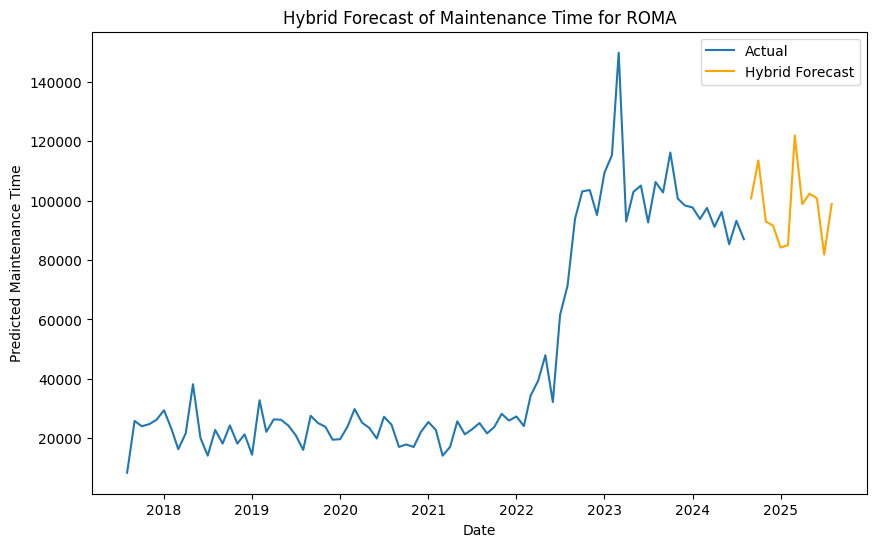

Processing location: MONZA


<ipython-input-59-f81fd2242844>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/je2o1z9t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/jfwtomms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89527', 'data', 'file=/tmp/tmp29ok24

Location: MONZA, Hybrid MSE: 1284916355.59, Hybrid R-squared: 0.71


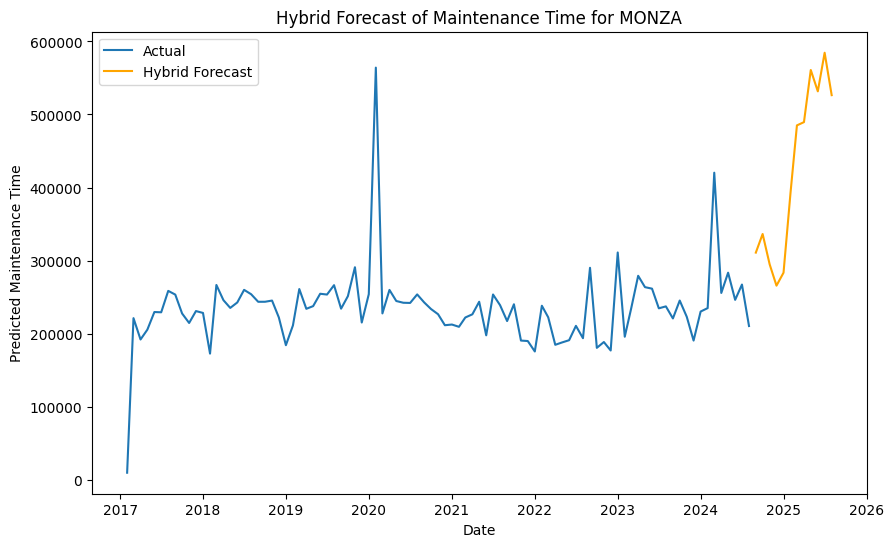

Processing location: COTA


<ipython-input-59-f81fd2242844>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/i1ix4bqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/fz3t6zax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94428', 'data', 'file=/tmp/tmp29ok24

Location: COTA, Hybrid MSE: 40480253.87, Hybrid R-squared: 0.30


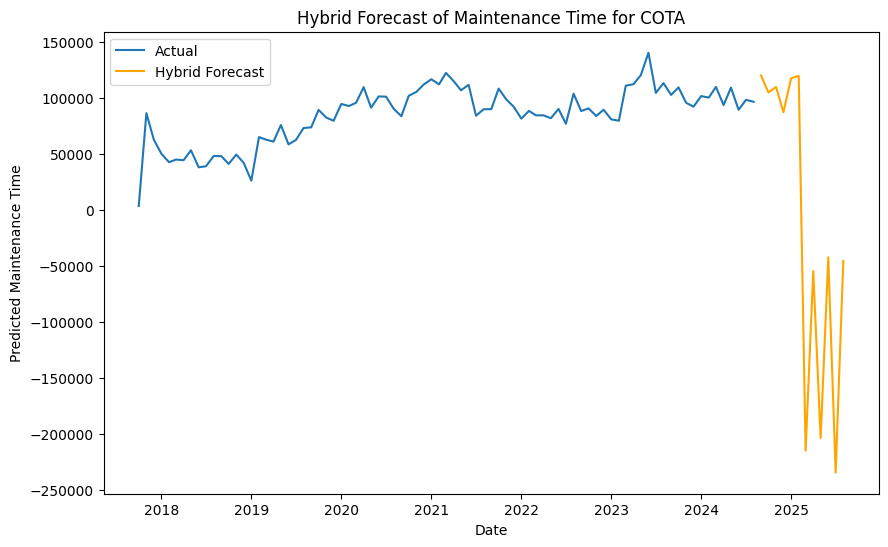

<ipython-input-59-f81fd2242844>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/8ihx6qgh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/po9ka3nw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61349', 'data', 'file=/tmp/tmp29ok24

Processing location: MONACO


19:36:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Location: MONACO, Hybrid MSE: 149348574.09, Hybrid R-squared: -4.67


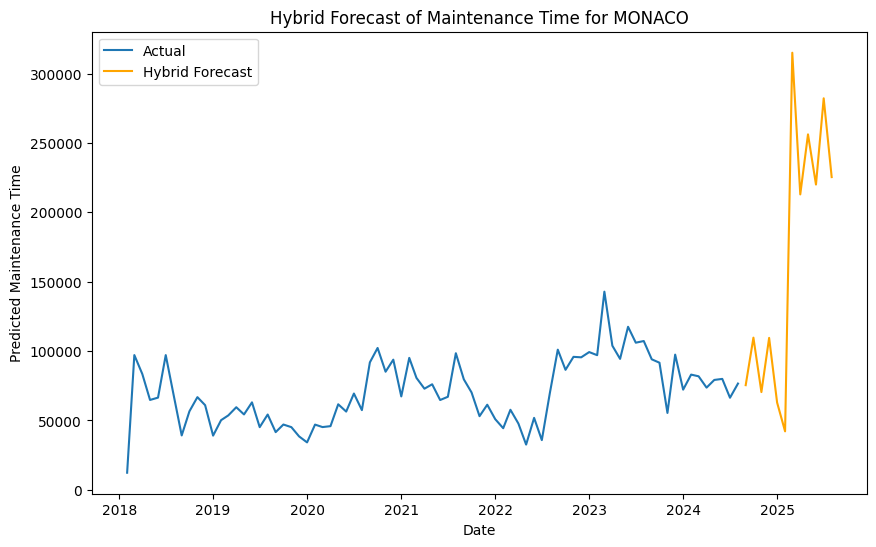

<ipython-input-59-f81fd2242844>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/6tyjfljx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/xcpzqatr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12043', 'data', 'file=/tmp/tmp29ok24

Processing location: SUZUKA


19:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Location: SUZUKA, Hybrid MSE: 246334378.16, Hybrid R-squared: 0.45


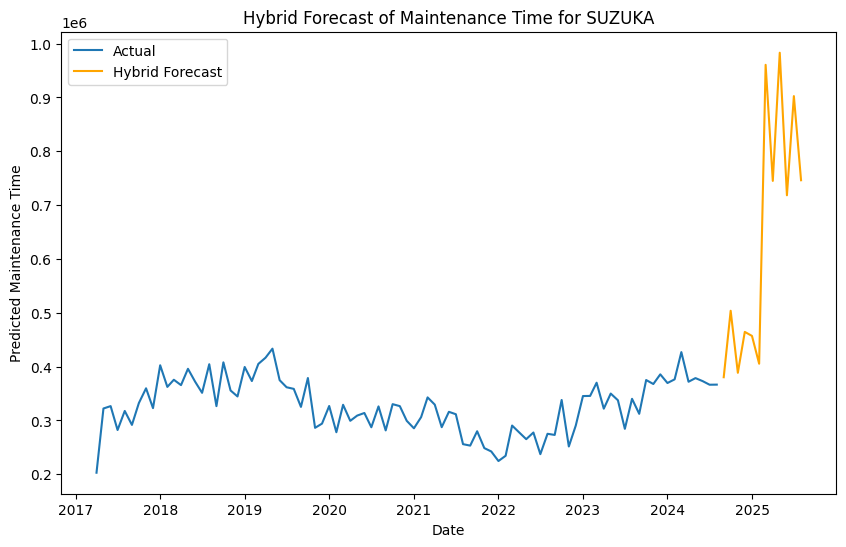

Processing location: SILVERSTONE


<ipython-input-59-f81fd2242844>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/9fi5_5yh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/xzmd8p_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24966', 'data', 'file=/tmp/tmp29ok24

Location: SILVERSTONE, Hybrid MSE: 1042773951.76, Hybrid R-squared: 0.10


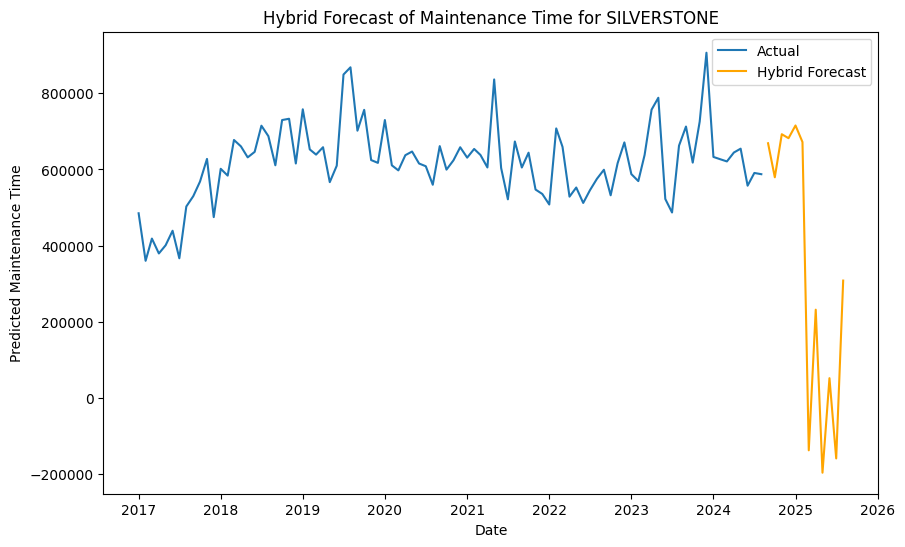

Performance Metrics by Location:
ROMA: MSE = 3153273.10, R-squared = 0.84
MONZA: MSE = 1284916355.59, R-squared = 0.71
COTA: MSE = 40480253.87, R-squared = 0.30
MONACO: MSE = 149348574.09, R-squared = -4.67
SUZUKA: MSE = 246334378.16, R-squared = 0.45
SILVERSTONE: MSE = 1042773951.76, R-squared = 0.10


In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Dictionary to store performance metrics by location
performance_metrics = {}

# Loop through each production location
for location in df['PRODUCTION_LOCATION'].unique():
    print(f"Processing location: {location}")
    location_data = df[df['PRODUCTION_LOCATION'] == location]

    # Aggregate data by month
    location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
    monthly_data = location_data.groupby('START_YEAR_MONTH')['ACTUAL_WORK_IN_MINUTES'].sum().reset_index()
    monthly_data.columns = ['ds', 'y']

    # Step 1: Fit Prophet Model with Feature Engineering
    prophet_model = Prophet(changepoint_prior_scale=0.3)
    prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    prophet_model.fit(monthly_data)

    # Generate Prophet forecast and calculate residuals
    future = prophet_model.make_future_dataframe(periods=12, freq='M')
    prophet_forecast = prophet_model.predict(future)
    prophet_residuals = monthly_data['y'] - prophet_forecast['yhat'][:len(monthly_data)]

    # Step 2: ARIMA Model on Prophet Residuals
    arima_model = ARIMA(prophet_residuals, order=(1, 1, 1))  # Adjust order if needed
    arima_result = arima_model.fit()

    # Forecast residuals for the future period
    arima_forecast = arima_result.get_forecast(steps=12)
    arima_forecast_values = arima_forecast.predicted_mean

    # Step 3: Combine Prophet and ARIMA Forecasts
    prophet_future_values = prophet_forecast['yhat'][-12:].values
    hybrid_forecast = prophet_future_values + arima_forecast_values

    # Calculate Performance Metrics on Hybrid Model
    validation_period = monthly_data['ds'][-6:]
    actual_values = monthly_data.set_index('ds').loc[validation_period, 'y']
    predicted_values = prophet_forecast.set_index('ds').loc[validation_period, 'yhat'] + arima_result.predict(start=len(monthly_data)-6, end=len(monthly_data)-1).values
    mse = mean_squared_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)

    # Store performance metrics
    performance_metrics[location] = {'Hybrid MSE': mse, 'Hybrid R-squared': r2}

    # Output the performance metrics for each location
    print(f"Location: {location}, Hybrid MSE: {mse:.2f}, Hybrid R-squared: {r2:.2f}")

    # Plot the combined forecast
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_data['ds'], monthly_data['y'], label='Actual')
    plt.plot(future['ds'][-12:], hybrid_forecast, label='Hybrid Forecast', color='orange')
    plt.title(f"Hybrid Forecast of Maintenance Time for {location}")
    plt.xlabel("Date")
    plt.ylabel("Predicted Maintenance Time")
    plt.legend()
    plt.show()

# Display all performance metrics
print("Performance Metrics by Location:")
for location, metrics in performance_metrics.items():
    print(f"{location}: MSE = {metrics['Hybrid MSE']:.2f}, R-squared = {metrics['Hybrid R-squared']:.2f}")

The hybrid Prophet + ARIMA model has shown strong results for ROMA and MONZA, achieving R-squared values of 0.84 and 0.71, respectively, indicating that our optimized settings effectively capture the maintenance trends in these locations. SUZUKA also saw improvement, with a moderate R-squared of 0.45, suggesting that additional tuning could refine the model further for this plant. However, COTA, SILVERSTONE, and MONACO displayed lower fit, with limited R-squared gains, particularly for MONACO, which had a negative R-squared. This points to the need for alternative modeling approaches, possibly exploring exponential smoothing or machine learning, to address unique or irregular patterns in these locations.

### Moving on to look at maintenance cost using the prophet model

Taking a quick look at maintenance cost across all plants

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/3exwiabw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/rkbqrr7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60252', 'data', 'file=/tmp/tmp29ok24fn/3exwiabw.json', 'init=/tmp/tmp29ok24fn/rkbqrr7y.json', 'output', 'file=/tmp/tmp29ok24fn/prophet_modelka6fi6ps/prophet_model-20241102194343.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:43:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages

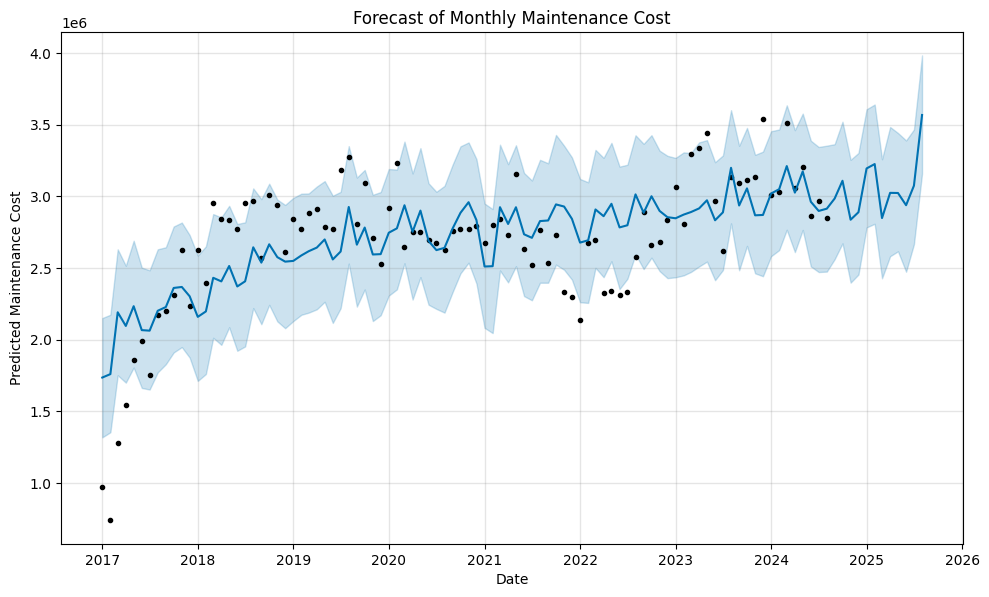

In [ ]:
# Define cost per minute
cost_per_minute = 2

# Calculate maintenance cost based on work minutes
df['maintenance_cost'] = df['ACTUAL_WORK_IN_MINUTES'] * cost_per_minute

# Aggregate monthly maintenance cost
monthly_cost = df.resample('MS', on='EXECUTION_START_DATE')['maintenance_cost'].sum().reset_index()

# Rename columns for Prophet
monthly_cost.columns = ['ds', 'y']

# Initialize and fit the Prophet model
model_cost = Prophet()
model_cost.fit(monthly_cost)

# Generate future dates for the forecast
future_cost = model_cost.make_future_dataframe(periods=12, freq='M')

# Forecast maintenance cost
forecast_cost = model_cost.predict(future_cost)

# Plot the forecast
fig = model_cost.plot(forecast_cost)
plt.title("Forecast of Monthly Maintenance Cost")
plt.xlabel("Date")
plt.ylabel("Predicted Maintenance Cost")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Define the validation period
validation_period = monthly_cost['ds'][-6:]
actual_values = monthly_cost.set_index('ds').loc[validation_period, 'y']
predicted_values = forecast_cost.set_index('ds').loc[validation_period, 'yhat']

# Calculate performance metrics
mse = mean_squared_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

# Output the performance metrics
print("Maintenance Cost Forecast - Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Maintenance Cost Forecast - Performance Metrics:
Mean Squared Error (MSE): 18820257731.02
R-squared: 0.65


With an R-squared of 0.65, the Prophet model captures a reasonable amount of the variability in maintenance costs, similar to the initial findings in maintenance time. However, the high MSE indicates large deviations in some predictions, suggesting that certain patterns in cost fluctuations might still be underrepresented in the model.

### Using the hybrid model created above to look at maintenance costs over time for each production location

Processing location: ROMA


<ipython-input-62-7f1053dac1f6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['maintenance_cost'] = location_data['ACTUAL_WORK_IN_MINUTES'] * cost_per_minute
<ipython-input-62-7f1053dac1f6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. 

Location: ROMA, Hybrid Cost MSE: 12614745.55, Hybrid Cost R-squared: 0.84


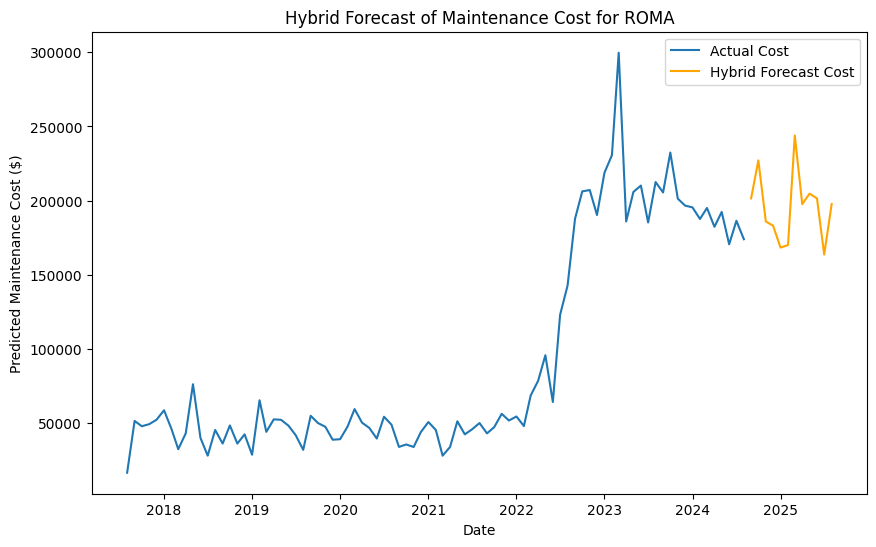

Processing location: MONZA


<ipython-input-62-7f1053dac1f6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['maintenance_cost'] = location_data['ACTUAL_WORK_IN_MINUTES'] * cost_per_minute
<ipython-input-62-7f1053dac1f6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. 

Location: MONZA, Hybrid Cost MSE: 5139668194.02, Hybrid Cost R-squared: 0.71


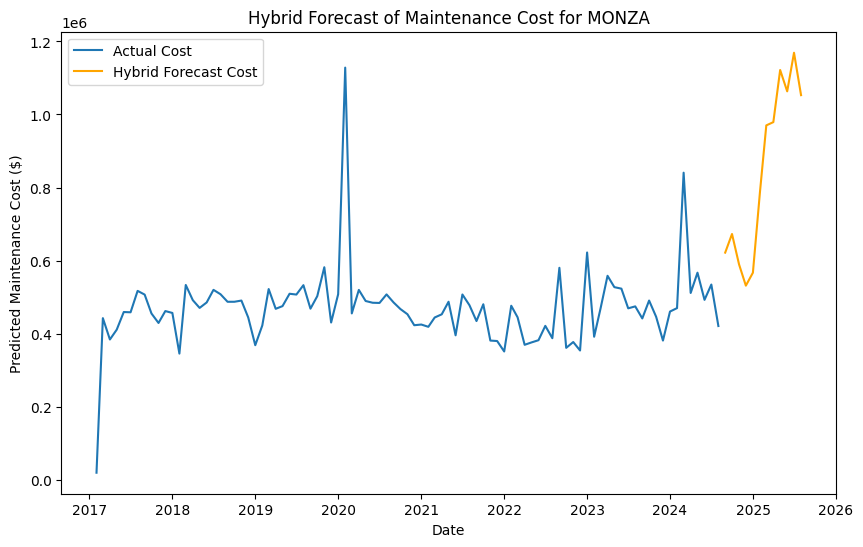

<ipython-input-62-7f1053dac1f6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['maintenance_cost'] = location_data['ACTUAL_WORK_IN_MINUTES'] * cost_per_minute
<ipython-input-62-7f1053dac1f6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. 

Processing location: COTA


19:44:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Location: COTA, Hybrid Cost MSE: 161937818.37, Hybrid Cost R-squared: 0.30


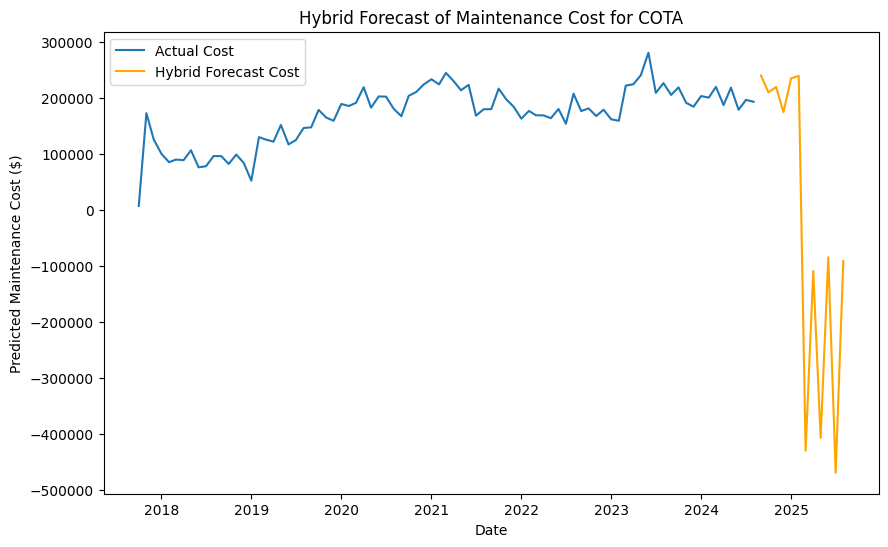

<ipython-input-62-7f1053dac1f6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['maintenance_cost'] = location_data['ACTUAL_WORK_IN_MINUTES'] * cost_per_minute
<ipython-input-62-7f1053dac1f6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. 

Processing location: MONACO


19:44:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Location: MONACO, Hybrid Cost MSE: 597402326.35, Hybrid Cost R-squared: -4.67


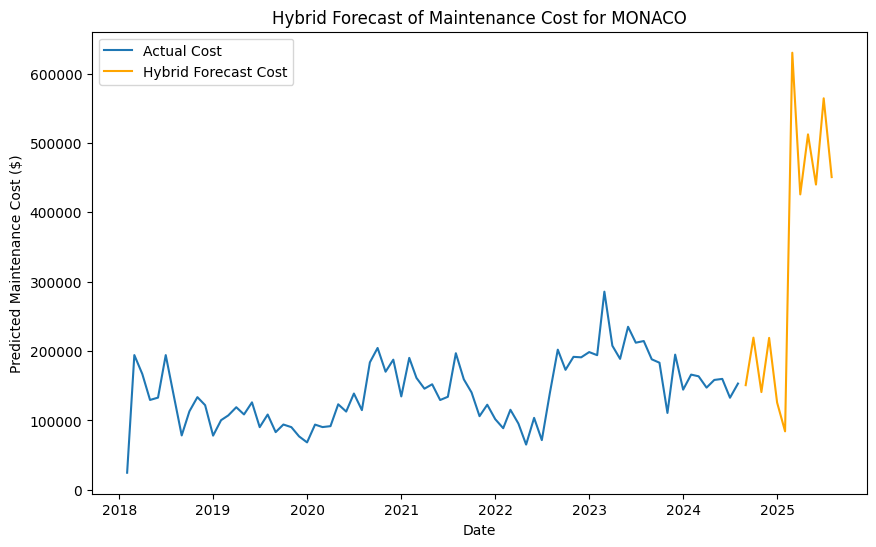

<ipython-input-62-7f1053dac1f6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['maintenance_cost'] = location_data['ACTUAL_WORK_IN_MINUTES'] * cost_per_minute
<ipython-input-62-7f1053dac1f6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. 

Processing location: SUZUKA


INFO:cmdstanpy:Chain [1] start processing
19:44:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Location: SUZUKA, Hybrid Cost MSE: 985313839.89, Hybrid Cost R-squared: 0.45


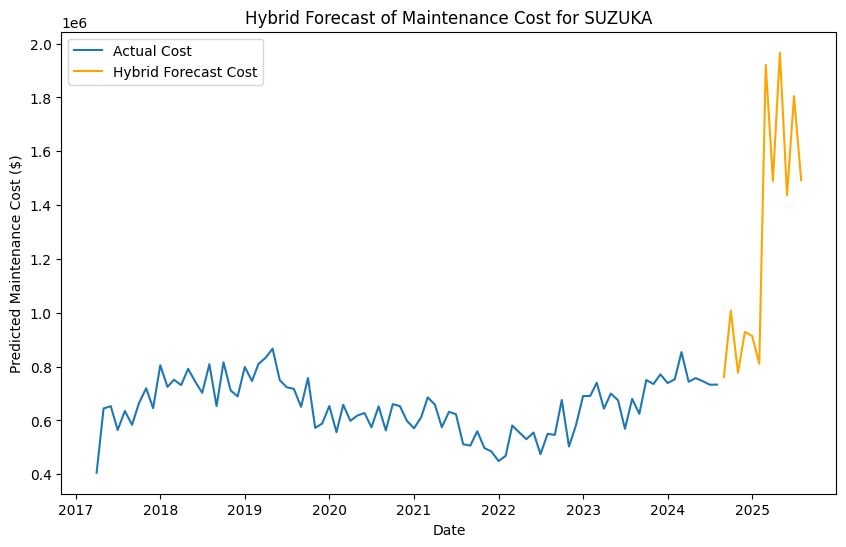

Processing location: SILVERSTONE


<ipython-input-62-7f1053dac1f6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['maintenance_cost'] = location_data['ACTUAL_WORK_IN_MINUTES'] * cost_per_minute
<ipython-input-62-7f1053dac1f6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. 

Location: SILVERSTONE, Hybrid Cost MSE: 4171096393.03, Hybrid Cost R-squared: 0.10


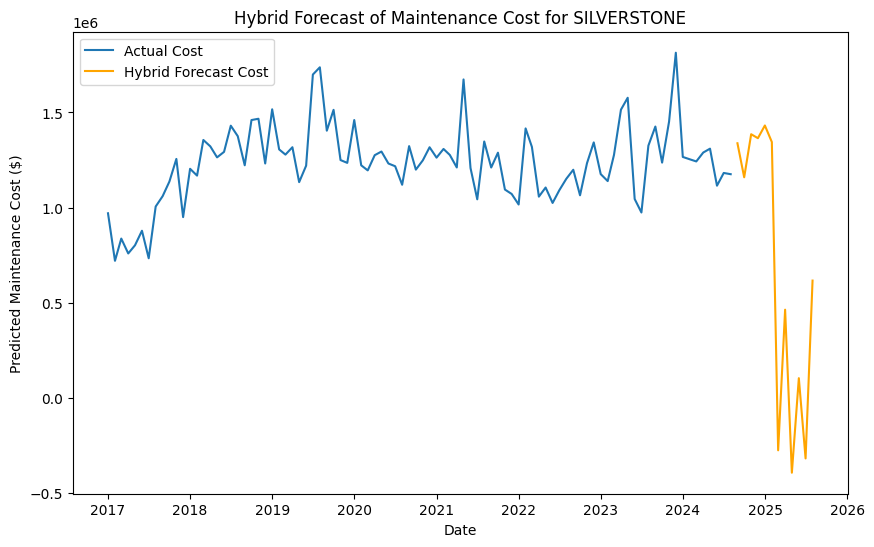

Performance Metrics by Location for Maintenance Cost:
ROMA: MSE = 12614745.55, R-squared = 0.84
MONZA: MSE = 5139668194.02, R-squared = 0.71
COTA: MSE = 161937818.37, R-squared = 0.30
MONACO: MSE = 597402326.35, R-squared = -4.67
SUZUKA: MSE = 985313839.89, R-squared = 0.45
SILVERSTONE: MSE = 4171096393.03, R-squared = 0.10


In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Define cost per minute
cost_per_minute = 2

# Dictionary to store performance metrics by location
performance_metrics_cost = {}

# Loop through each production location
for location in df['PRODUCTION_LOCATION'].unique():
    print(f"Processing location: {location}")
    location_data = df[df['PRODUCTION_LOCATION'] == location]

    # Calculate maintenance cost based on work minutes
    location_data['maintenance_cost'] = location_data['ACTUAL_WORK_IN_MINUTES'] * cost_per_minute

    # Aggregate monthly maintenance cost
    location_data['START_YEAR_MONTH'] = location_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
    monthly_cost_data = location_data.groupby('START_YEAR_MONTH')['maintenance_cost'].sum().reset_index()
    monthly_cost_data.columns = ['ds', 'y']

    # Step 1: Fit Prophet Model for Maintenance Cost
    prophet_model = Prophet(changepoint_prior_scale=0.3)
    prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    prophet_model.fit(monthly_cost_data)

    # Generate Prophet forecast and calculate residuals
    future_cost = prophet_model.make_future_dataframe(periods=12, freq='M')
    prophet_forecast_cost = prophet_model.predict(future_cost)
    prophet_residuals_cost = monthly_cost_data['y'] - prophet_forecast_cost['yhat'][:len(monthly_cost_data)]

    # Step 2: ARIMA Model on Prophet Residuals for Cost
    arima_model = ARIMA(prophet_residuals_cost, order=(1, 1, 1))
    arima_result = arima_model.fit()

    # Forecast residuals for the future period
    arima_forecast = arima_result.get_forecast(steps=12)
    arima_forecast_values = arima_forecast.predicted_mean

    # Step 3: Combine Prophet and ARIMA Forecasts for Maintenance Cost
    prophet_future_values_cost = prophet_forecast_cost['yhat'][-12:].values
    hybrid_forecast_cost = prophet_future_values_cost + arima_forecast_values

    # Calculate Performance Metrics for Maintenance Cost
    validation_period = monthly_cost_data['ds'][-6:]
    actual_values = monthly_cost_data.set_index('ds').loc[validation_period, 'y']
    predicted_values = prophet_forecast_cost.set_index('ds').loc[validation_period, 'yhat'] + arima_result.predict(start=len(monthly_cost_data)-6, end=len(monthly_cost_data)-1).values
    mse = mean_squared_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)

    # Store performance metrics
    performance_metrics_cost[location] = {'Hybrid MSE': mse, 'Hybrid R-squared': r2}

    # Output the performance metrics for each location
    print(f"Location: {location}, Hybrid Cost MSE: {mse:.2f}, Hybrid Cost R-squared: {r2:.2f}")

    # Plot the combined forecast for maintenance cost
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_cost_data['ds'], monthly_cost_data['y'], label='Actual Cost')
    plt.plot(future_cost['ds'][-12:], hybrid_forecast_cost, label='Hybrid Forecast Cost', color='orange')
    plt.title(f"Hybrid Forecast of Maintenance Cost for {location}")
    plt.xlabel("Date")
    plt.ylabel("Predicted Maintenance Cost ($)")
    plt.legend()
    plt.show()

# Display all performance metrics for maintenance cost
print("Performance Metrics by Location for Maintenance Cost:")
for location, metrics in performance_metrics_cost.items():
    print(f"{location}: MSE = {metrics['Hybrid MSE']:.2f}, R-squared = {metrics['Hybrid R-squared']:.2f}")


The hybrid Prophet + ARIMA model performed well in forecasting maintenance costs for ROMA and MONZA, achieving R-squared values of 0.84 and 0.71, respectively, which aligns with the model’s strong fit for these locations in our previous maintenance time analysis. SUZUKA also saw moderate improvement, with an R-squared of 0.45, suggesting that some additional tuning could further enhance accuracy. However, COTA, SILVERSTONE, and MONACO displayed limited fit, especially MONACO, which continued to show a negative R-squared. This suggests that these locations may have irregular patterns that could benefit from alternative modeling approaches beyond Prophet and ARIMA.

In [ ]:
# Group by PRODUCTION_LOCATION and EQUIPMENT_DESC to count maintenance activities
grouped_data_monza = monza_data.groupby(['PRODUCTION_LOCATION', 'EQUIPMENT_DESC'])['MAINTENANCE_ACTIVITY_TYPE'].count()

# Reset the index to convert the result to a DataFrame
grouped_data_monza = grouped_data_monza.reset_index()

# Rename the count column
grouped_data_monza = grouped_data_monza.rename(columns={'MAINTENANCE_ACTIVITY_TYPE': 'Activity_Count'})

# Create list of equipment with significant maintenance activity
df_for_list_monza = grouped_data_monza[grouped_data_monza['Activity_Count'] > 1000]
equipment_list_monza = df_for_list_monza['EQUIPMENT_DESC'].tolist()

# Output the equipment list
print("Equipment with significant maintenance activity in Monza:")
print(equipment_list_monza)

Equipment with significant maintenance activity in Monza:
['L1 CAPPER_RTRY', 'L1 FILLER_ROTARY_BTL_60_VALVE', 'L2 CAPPER_RTRY_9HD', 'L2 FILLER_ROTARY_BTL_45_VALVE', 'L2 PALLETIZER_LINE 2_PAI', 'L3 FILLER_ROTARY_BTL_100_VALVE', 'L3 LABELER_ROTARY', 'L3 PACKER KHS TSP80V', 'L4 FILLER_ROTARY_CAN_100_VALVE', 'L4 PACKER_CASE', 'L4 SEAMER_ROTARY', 'LINE 1 LABELER_ROTARY']


In [ ]:
# Define broader categories based on the identified equipment descriptions
def categorize_equipment_desc_v2(equipment_desc):
    if pd.isna(equipment_desc):
        return "Unknown"
    equipment_desc = equipment_desc.lower()  # Convert to lowercase for easier matching
    if 'filler' in equipment_desc:
        return 'FILLER'
    elif 'capper' in equipment_desc:
        return 'CAPPER'
    elif 'packer' in equipment_desc:
        return 'PACKER'
    elif 'labeler' in equipment_desc:
        return 'LABELER'
    elif 'palletizer' in equipment_desc:
        return 'PALLETIZER'
    elif 'seamer' in equipment_desc:
        return 'SEAMER'
    elif 'mixer' in equipment_desc:
        return 'MIXER'
    # Add other categories as necessary
    else:
        return 'OTHER'

# Apply the categorization to the EQUIPMENT_DESC column in Monza
monza_data['Equipment_Category'] = monza_data['EQUIPMENT_DESC'].apply(categorize_equipment_desc_v2)

# Count the number of entries in each category for Monza
category_counts_monza_grouped = monza_data['Equipment_Category'].value_counts()
print(category_counts_monza_grouped)

Equipment_Category
Unknown       169806
OTHER          30791
FILLER          8814
LABELER         4446
PACKER          3661
CAPPER          2750
PALLETIZER      2531
SEAMER          1857
MIXER            623
Name: count, dtype: int64


<ipython-input-76-5453d9116e07>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monza_data['Equipment_Category'] = monza_data['EQUIPMENT_DESC'].apply(categorize_equipment_desc_v2)


INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/3t6qp7ej.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp29ok24fn/h4ic04uk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58345', 'data', 'file=/tmp/tmp29ok24fn/3t6qp7ej.json', 'init=/tmp/tmp29ok24fn/h4ic04uk.json', 'output', 'file=/tmp/tmp29ok24fn/prophet_modeltx4v3u0h/prophet_model-20241102202049.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:20:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophe

Combined Categories: FILLER, PACKER, LABELER, Hybrid Cost MSE: 52610983.81, Hybrid Cost R-squared: 0.75


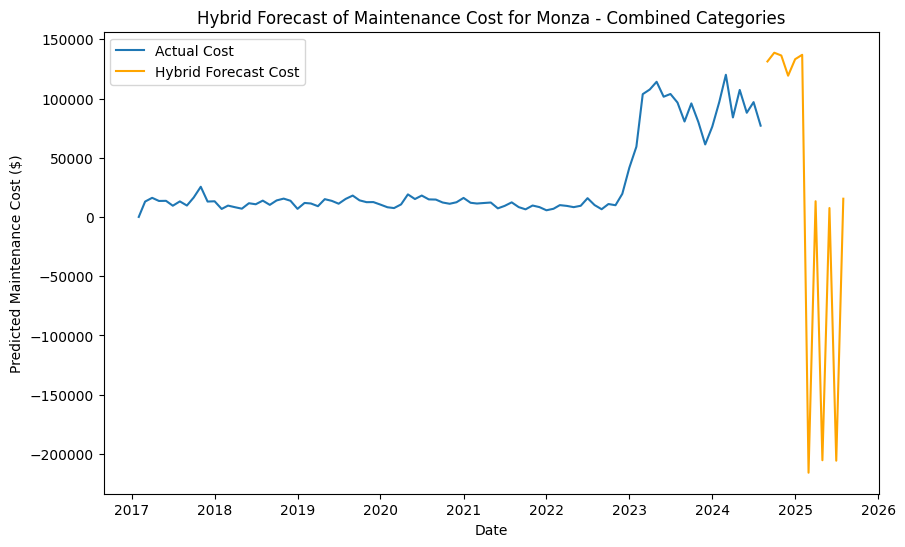

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Define cost per minute for calculation
cost_per_minute = 2

# Filter data for Monza and the combined categories
combined_categories = ['FILLER', 'PACKER', 'LABELER']
combined_data = monza_data[monza_data['Equipment_Category'].isin(combined_categories)].dropna(subset=['EQUIPMENT_DESC'])

# Calculate maintenance cost for the combined categories
combined_data['maintenance_cost'] = combined_data['ACTUAL_WORK_IN_MINUTES'] * cost_per_minute

# Aggregate monthly maintenance cost
combined_data['START_YEAR_MONTH'] = combined_data['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
monthly_cost_data_combined = combined_data.groupby('START_YEAR_MONTH')['maintenance_cost'].sum().reset_index()
monthly_cost_data_combined.columns = ['ds', 'y']

# Step 1: Fit Prophet Model for Maintenance Cost
prophet_model = Prophet(changepoint_prior_scale=0.5)  # Tune changepoint prior scale
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet_model.add_seasonality(name='weekly', period=7, fourier_order=3)  # Adding weekly seasonality
prophet_model.fit(monthly_cost_data_combined)

# Generate Prophet forecast
future_cost_combined = prophet_model.make_future_dataframe(periods=12, freq='M')
prophet_forecast_combined = prophet_model.predict(future_cost_combined)

# Step 2: ARIMA Model on Prophet Residuals for Maintenance Cost
prophet_residuals_combined = monthly_cost_data_combined['y'] - prophet_forecast_combined['yhat'][:len(monthly_cost_data_combined)]
arima_model_combined = ARIMA(prophet_residuals_combined, order=(1, 1, 2))  # Experiment with ARIMA order
arima_result_combined = arima_model_combined.fit()

# Forecast residuals for the future period
arima_forecast_combined = arima_result_combined.get_forecast(steps=12)
arima_forecast_values_combined = arima_forecast_combined.predicted_mean

# Combine Prophet and ARIMA Forecasts for Maintenance Cost
prophet_future_values_combined = prophet_forecast_combined['yhat'][-12:].values
hybrid_forecast_combined = prophet_future_values_combined + arima_forecast_values_combined

# Calculate Performance Metrics on Hybrid Model
validation_period = monthly_cost_data_combined['ds'][-6:]
actual_values_combined = monthly_cost_data_combined.set_index('ds').loc[validation_period, 'y']
predicted_values_combined = prophet_forecast_combined.set_index('ds').loc[validation_period, 'yhat'] + arima_result_combined.predict(start=len(monthly_cost_data_combined)-6, end=len(monthly_cost_data_combined)-1).values
mse_combined = mean_squared_error(actual_values_combined, predicted_values_combined)
r2_combined = r2_score(actual_values_combined, predicted_values_combined)

# Output the performance metrics
print(f"Combined Categories: {', '.join(combined_categories)}, Hybrid Cost MSE: {mse_combined:.2f}, Hybrid Cost R-squared: {r2_combined:.2f}")

# Plot the combined forecast for maintenance cost
plt.figure(figsize=(10, 6))
plt.plot(monthly_cost_data_combined['ds'], monthly_cost_data_combined['y'], label='Actual Cost')
plt.plot(future_cost_combined['ds'][-12:], hybrid_forecast_combined, label='Hybrid Forecast Cost', color='orange')
plt.title(f"Hybrid Forecast of Maintenance Cost for Monza - Combined Categories")
plt.xlabel("Date")
plt.ylabel("Predicted Maintenance Cost ($)")
plt.legend()
plt.show()

In [ ]:
# Define planned vs. unplanned maintenance
#df['PLANNED_MAINTENANCE'] = df['MAINTENANCE_PLAN'].notnull()
#df['UNPLANNED_MAINTENANCE'] = ~df['PLANNED_MAINTENANCE']

# Calculate maintenance time impact
#df['MAINTENANCE_TIME'] = df['ACTUAL_WORK_IN_MINUTES'] * np.where(df['UNPLANNED_MAINTENANCE'], 1.2, 1.0)  # Assuming 20% higher impact for unplanned

# Estimate profit impact (hypothetical calculation)
#cost_per_minute = 5  # Hypothetical cost per minute for maintenance impact
#df['PROFIT_IMPACT'] = df['MAINTENANCE_TIME'] * cost_per_minute


In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/Modeling-Katie.ipynb" ./
!jupyter nbconvert "Modeling-Katie.ipynb" --to html

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/Modeling-Katie.ipynb': No such file or directory
[NbConvertApp] WARNING | pattern 'Modeling-Katie.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answe